In [47]:
import itertools
import glob
from collections import defaultdict
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gimmemotifs.motif import Motif, read_motifs
from gimmemotifs.fasta import Fasta
from gimmemotifs.scanner import Scanner
from nopeak_utils.nopeak import NoPeakMotif
from tfomics import ReferenceGenome

%matplotlib inline

In [41]:
ReferenceGenome.offset = 25
genome = ReferenceGenome("genome/hg19.fa.bz2")

In [3]:
all_motifs = list(itertools.chain.from_iterable(NoPeakMotif.from_file(infile, strip_edges=True) for infile in glob.glob("ctcf/data/*.motifs.*")))

In [4]:
high_kmer_motifs = [motif for motif in all_motifs if int(motif.kmer_count) > 200]
print(len(high_kmer_motifs))

10


In [5]:
high_ic_motifs = [ motif for motif in all_motifs if motif.information_content > 22.5 ]
print(len(high_ic_motifs))

4


/Users/oalmelid/anaconda3/envs/nopeak_utils/lib/python3.8/site-packages/gimmemotifs/motif/__init__.py:290: RuntimeWarning: divide by zero encountered in log2
  return ((self.ppm * np.log2(self.ppm)).sum(1) + 2).sum()
/Users/oalmelid/anaconda3/envs/nopeak_utils/lib/python3.8/site-packages/gimmemotifs/motif/__init__.py:290: RuntimeWarning: invalid value encountered in multiply
  return ((self.ppm * np.log2(self.ppm)).sum(1) + 2).sum()


In [6]:
jaspar_motifs = read_motifs("jaspar/CTCF/MA0139.1.jaspar", fmt="jaspar") #+ [m for m in read_motifs() if "CTCF" in m.factors['direct']]

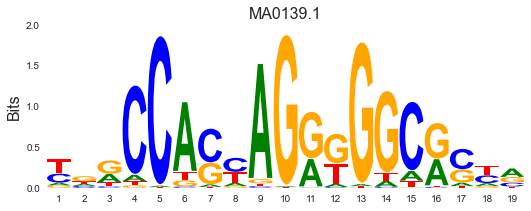

In [7]:
jaspar_motifs[0].plot_logo()

In [8]:
asb_data = dd.read_csv("ctcf/asb/*.csv", include_path_column=True)
asb_data.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
0,rs1043897,chr1,230416399,G,T,6,2,8,0.750000,0.498905,0.670986,0.266662,0.814342,0.143168,0.540502,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
1,rs10494924,chr1,209527706,T,G,38,43,81,0.469136,0.507349,0.413892,0.452832,0.655640,0.052384,0.554236,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
2,rs1061511,chr1,160189500,C,A,80,62,142,0.563380,0.536405,0.599027,0.387567,0.544682,0.040788,0.466124,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
3,rs10800374,chr1,168606715,G,A,9,32,41,0.219512,0.514544,0.347637,0.220050,0.527530,0.079390,0.373790,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
4,rs10911467,chr1,183885406,A,G,65,30,95,0.684211,0.496446,0.668285,0.422900,0.632446,0.053866,0.527673,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...


In [9]:
asb_sites = asb_data.compute()

In [10]:
asb_peak_sites = asb_sites[asb_sites.peak].reset_index(drop=True)
asb_peak_sites.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
0,rs1043897,chr1,230416399,G,T,6,2,8,0.750000,0.498905,0.670986,0.266662,0.814342,0.143168,0.540502,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
1,rs10494924,chr1,209527706,T,G,38,43,81,0.469136,0.507349,0.413892,0.452832,0.655640,0.052384,0.554236,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
2,rs1061511,chr1,160189500,C,A,80,62,142,0.563380,0.536405,0.599027,0.387567,0.544682,0.040788,0.466124,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
3,rs10800374,chr1,168606715,G,A,9,32,41,0.219512,0.514544,0.347637,0.220050,0.527530,0.079390,0.373790,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...
4,rs10911467,chr1,183885406,A,G,65,30,95,0.684211,0.496446,0.668285,0.422900,0.632446,0.053866,0.527673,False,True,/Users/oalmelid/src/prototypes/motifs/ctcf/asb...


In [11]:
class ScoreSet():
    def __init__(self, sites, motifs, genome):
        self.motifs = motifs
        self.genome = genome
        sequences = sites.apply(self._get_sequences, axis=1)
        self.sites = sites.join(sequences)
        self.ref_matches = None
        self.alt_matches = None

    def _get_sequences(self, row):
        """Get ref and alt sequences for a given site"""
        sequence = self.genome.get_peak(row.CHROM, row.POS)
        ref_seq = sequence
        alt_seq = sequence[:genome.offset] + row.ALT + sequence[genome.offset+1:]
        return pd.Series({"ref_seq" : ref_seq, "alt_seq": alt_seq})

    def _score_sequences(self,fpr):
        scanner = Scanner()
        scanner.set_motifs(self.motifs)
        scanner.set_genome("hg19")
        scanner.set_threshold(fpr=fpr)
        self.ref_matches = list(scanner.scan(Fasta(fdict=self.sites.ref_seq.to_dict())))
        self.alt_matches = list(scanner.scan(Fasta(fdict=self.sites.alt_seq.to_dict())))

    def get_best_scores(self, fpr=0.05):
        # if self.ref_matches is None:
        self._score_sequences(fpr=fpr)

        scores = defaultdict(list)

        for ref_matches, alt_matches, rsid, ref_seq, alt_seq, ar in zip(self.ref_matches, 
                                                              self.alt_matches,
                                                              self.sites.ID,
                                                              self.sites.ref_seq,
                                                              self.sites.alt_seq,
                                                              self.sites["Corrected.AR"]):
            for ref_match_l, alt_match_l, motif in zip(ref_matches, alt_matches, self.motifs):
                ref_match, alt_match = None, None
                if ref_match_l:
                    ref_match = max(ref_match_l, key=lambda x:x[0])
                if alt_match_l:
                    alt_match = max(alt_match_l, key=lambda x:x[0])
                    
                if (ref_match is not None) or (alt_match is not None):
                    scores["motif"].append(str(motif))
                    scores["ar"].append(ar)
                    scores["id"].append(rsid)
                    if (alt_match is None) or ((ref_match is not None) and (ref_match[0] > alt_match[0])):
                        scores["ref_score"].append(ref_match[0])
                        scores["pos"].append(ref_match[1])
                        scores["strand"].append(ref_match[2])
                        scores["alt_score"].append(ScoreSet.re_score(alt_seq, ref_match[1], ref_match[2], motif))
                        
                    else:
                        scores["alt_score"].append(alt_match[0])
                        scores["pos"].append(alt_match[1])
                        scores["strand"].append(alt_match[2])
                        scores["ref_score"].append(ScoreSet.re_score(ref_seq, alt_match[1], alt_match[2], motif))
        score_set = pd.DataFrame.from_dict(scores)
        score_set["score_diff"] = score_set.ref_score - score_set.alt_score
        return score_set
            
        
    @staticmethod
    def re_score(sequence, pos, strand, motif):
        length = len(motif.pfm)
        
        if strand < 0:
            motif = ~motif
    
        kmer = sequence[pos:pos+length]
        return motif.score_kmer(kmer)

    

In [12]:
# test = ScoreSet(asb_sites, jaspar_motifs + high_kmer_motifs, genome)
test = ScoreSet(asb_peak_sites, jaspar_motifs + high_kmer_motifs, genome)
# test = ScoreSet(asb_peak_sites, jaspar_motifs + high_ic_motifs, genome)
score_set = test.get_best_scores(fpr=0.01)

scanning:   0%|          | 0/31094 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/31094 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning: 100%|██████████| 31094/31094 [00:04<00:00, 6963.27 sequences/s]


In [13]:
print(len(score_set))
score_set.head()

9920


,motif,ar,id,ref_score,pos,strand,alt_score,score_diff
0,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.613056,rs1281378,10.235301,25,1,9.782410,0.452890
1,ENCFF000ROX_dedup.bam.motifs_0_rsnGCCCCCTGGTGG,0.613056,rs1281378,9.247956,28,-1,9.247956,0.000000
2,SRR357520_dedup.bam.motifs_0_rGnGCCCCCTGGTGG,0.613056,rs1281378,9.088966,28,-1,9.088966,0.000000
3,MA0139.1_ynrCCAsyAGrkGGCrsyn,0.409137,rs6685037,9.095202,9,1,6.584271,2.510931
4,ENCFF000ROX_dedup.bam.motifs_0_rsnGCCCCCTGGTGG,0.409137,rs6685037,9.252993,12,-1,3.916032,5.336961


In [14]:
len(score_set.id.unique())

509

In [15]:
len(asb_peak_sites.ID.unique())

9097

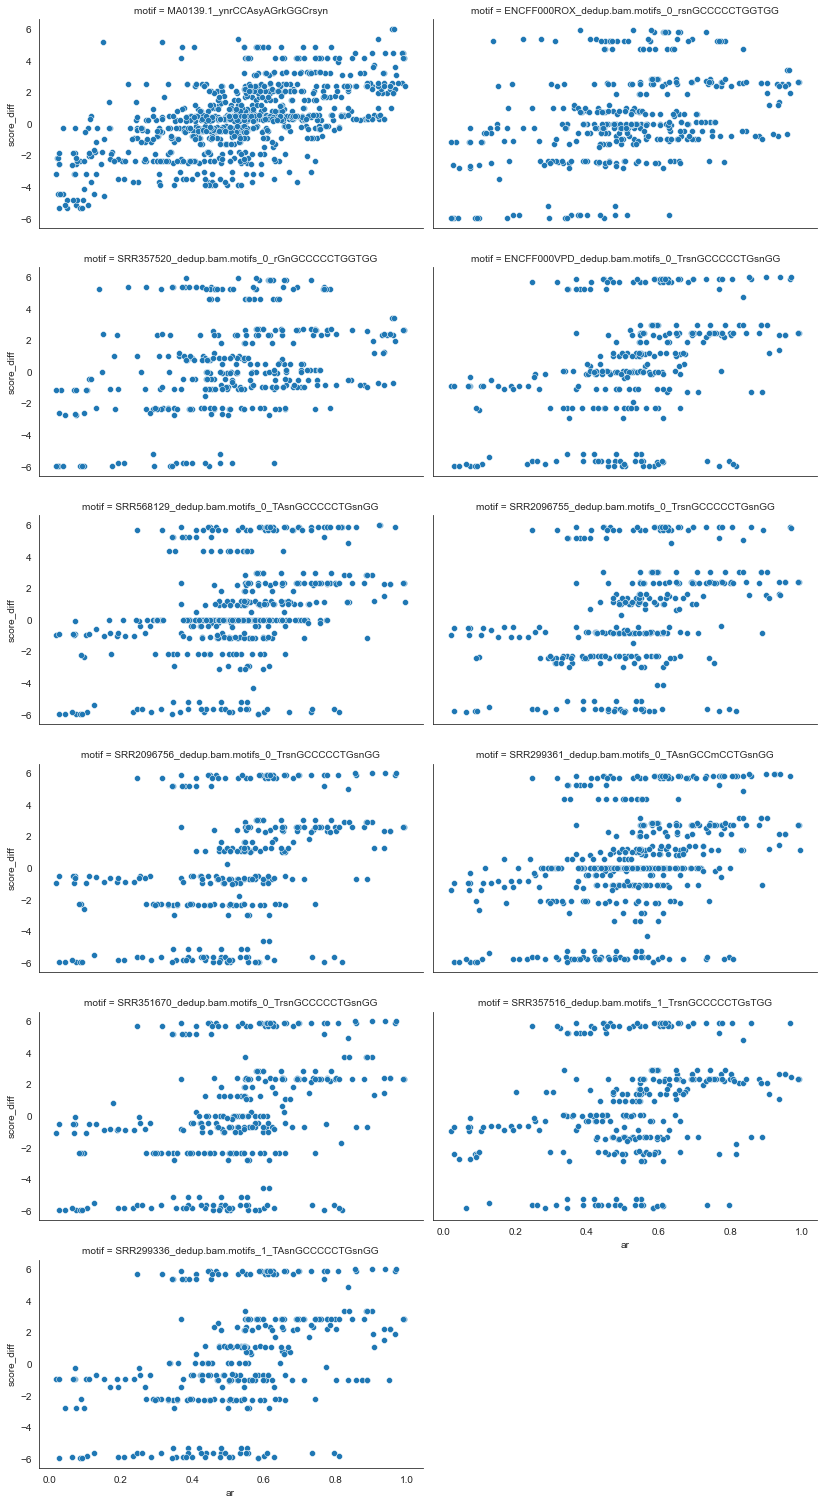

In [16]:
plot_data = score_set[round(score_set.score_diff, 6) != 0.]
g = sns.FacetGrid(plot_data, col="motif", height=3.5, aspect=1.65, col_wrap=2)
g.map(sns.scatterplot, "ar", "score_diff")


<AxesSubplot:xlabel='motif', ylabel='counts'>

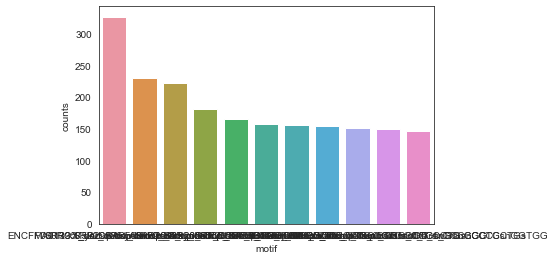

In [18]:
snp_count = pd.DataFrame(score_set.pivot(columns=("motif"), values=("id")).apply(lambda series: len(series.dropna().unique()), axis=0), columns=["counts"]).sort_values(by="counts", ascending=False).reset_index()
sns.barplot(data = snp_count, x="motif", y="counts")

# Other TFs

In [85]:
motif_dir = Path("other_tfs/motifs/")
samples = pd.read_csv("other_tfs/samples.csv")

motifs = defaultdict(list)

for index, row in samples.iterrows():
    motif_path = motif_dir / f"{row.run}_dedup.bam.motifs.txt"
    
    if motif_path.exists():
        motifs[row.transcription_factor] += NoPeakMotif.from_file(str(motif_dir / f"{row.run}_dedup.bam.motifs.txt"))

# CTCF is in a separate pipeline run, so pull that in manually
ctcf_motifs = list(itertools.chain.from_iterable(NoPeakMotif.from_file(infile, strip_edges=True) for infile in glob.glob("ctcf/data/*.motifs.*")))
motifs["CTCF"] = ctcf_motifs

high_kmer_motifs = {}
for factor, motif_list in motifs.items():
    high_kmer_motifs[factor] = list(sorted(motif_list, key=lambda motif: motif.kmer_count, reverse=True))[:5]


In [86]:
jaspar_motifs = defaultdict(list)

for file in Path("jaspar/").glob("**/*.jaspar"):
    jaspar_motifs[str(file.parent.name)] += read_motifs(str(file), fmt="jaspar")

In [87]:
merged_motifs = {}

for key in set(jaspar_motifs.keys()).union(set(high_kmer_motifs.keys())):
    merged_motifs[key] = jaspar_motifs.get(key, []) + high_kmer_motifs.get(key, [])

In [88]:
asb_data = dd.read_csv("other_tfs/asb/*.csv", include_path_column=True)
ctcf_asb_data = dd.read_csv("ctcf/asb/*.csv", include_path_column=True)
asb_data = dd.concat([asb_data, ctcf_asb_data])
asb_data = asb_data[asb_data.peak]
asb_data["cell_line"] = asb_data.apply(lambda row: Path(row.path).name.split("_")[0],  axis=1)
asb_data["tf"] = asb_data.apply(lambda row: Path(row.path).name.split(".")[0].split("_")[1],  axis=1)
asb_data = asb_data.compute().reset_index(drop=True)
asb_data.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path,cell_line,tf
0,rs10797566,chr1,235011530,T,G,5,3,8,0.625000,0.512786,0.583363,0.266722,0.782667,0.136032,0.524694,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
1,rs10911467,chr1,183885406,A,G,8,4,12,0.666667,0.497210,0.668285,0.265198,0.728607,0.121952,0.496902,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
2,rs10918683,chr1,167301998,T,G,11,3,14,0.785714,0.512786,0.688751,0.344016,0.804369,0.121399,0.574193,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
3,rs10919786,chr1,199946176,A,G,9,80,89,0.101124,0.497210,0.402452,0.088758,0.245197,0.042663,0.166978,True,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,0.644719,0.459938,0.722847,0.067081,0.591392,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1


In [89]:
score_sets = { factor : ScoreSet(asb_data[asb_data.tf == factor], motif_list, genome) for factor, motif_list in merged_motifs.items()}

In [90]:
scores = { factor : set.get_best_scores(fpr=0.05) for factor, set in score_sets.items() }

scanning:   0%|          | 0/4003 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/4003 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/9214 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/9214 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/31094 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
F

In [169]:
rsid_counts = {factor : len(set.ID.unique()) for factor, set in asb_data.groupby("tf")}
rsid_counts

{'CTCF': 9097, 'ESR1': 3923, 'FOXA1': 7775, 'NR3C1': 989}

In [168]:
correlations = defaultdict(dict)

for factor, score_set in scores.items():
    for motif, group in score_set.groupby("motif"):
        correlation = group.ar.corr(group.score_diff, method="spearman")
        correlations[factor][motif] = correlation
        print(f"{factor}, {motif}: {correlation}") 


ESR1, MA0112.1_CCAGGTCACCrTGrCCym: 0.18293988615635706
ESR1, MA0112.2_nnnnmAGGTCACCCTGACCy: 0.08729898794408004
ESR1, MA0112.3_nrGGTCACnrTGACCTk: 0.23899947288058404
ESR1, SRR1930094_dedup.bam.motifs_0_CsAnCTCAGCCTCnnn: 0.17393131069573456
ESR1, SRR3170062_dedup.bam.motifs_1_CwnCTCAGCCTCCsm: -0.545544725589981
ESR1, SRR7755784_dedup.bam.motifs_0_TrnnGCCCCCTGsTGG: 0.22056178073422492
ESR1, SRR7755811_dedup.bam.motifs_1_TrnnGCCmCCTGsTGG: 0.23589368943916061
ESR1, SRR7755832_dedup.bam.motifs_1_TAnnGCCCCCTGsTGG: 0.17163801815008708
NR3C1, ENCFF000NBX_dedup.bam.motifs_1_wnnCCAGGCTGAkGy: nan
NR3C1, MA0113.1_rrrAACATwmyGTyCTrn: 0.24758569682666995
NR3C1, MA0113.3_nrGwACAynrTGTwCyn: 0.42258488392898413
NR3C1, SRR351556_dedup.bam.motifs_1_rrknCCAGCCTsnnnT: -0.2195162759948775
FOXA1, MA0148.1_TGTTTrCwywG: 0.4242575719491183
FOXA1, MA0148.2_TGTTTrCwywG: 0.4505628616869892
FOXA1, MA0148.3_nnnnTGTTTACwywn: 0.48412698944865007
FOXA1, MA0148.4_nwGTAAACATnn: 0.4392021987054867
FOXA1, SRR1021802_dedup.

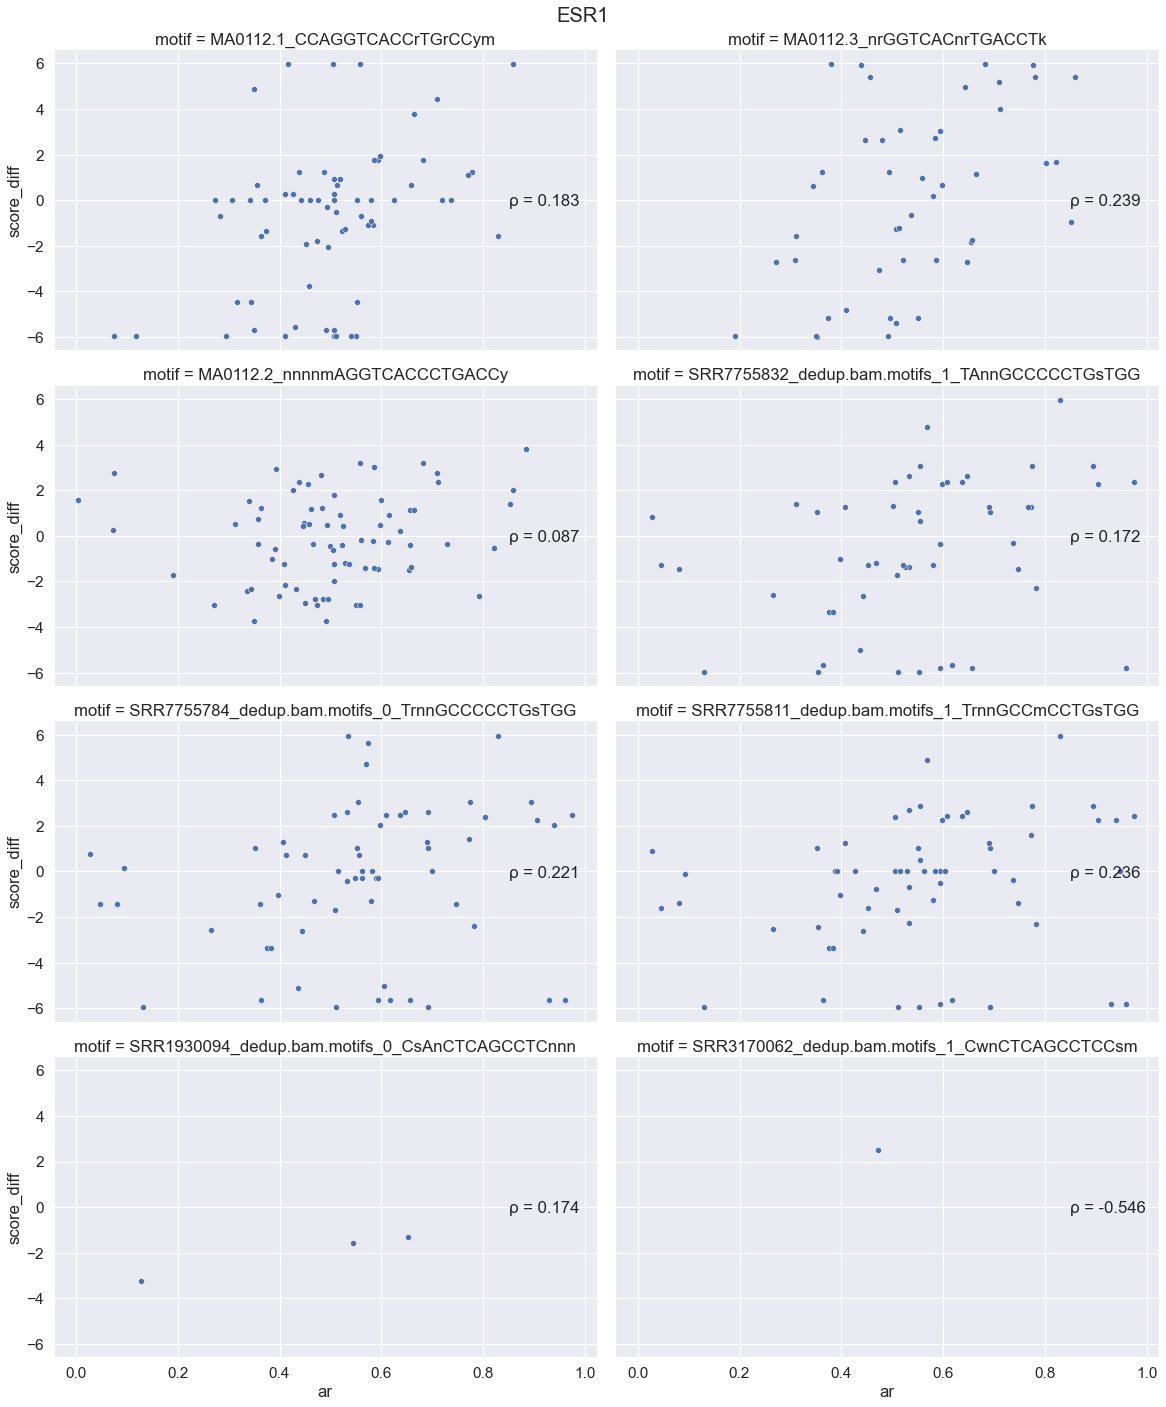

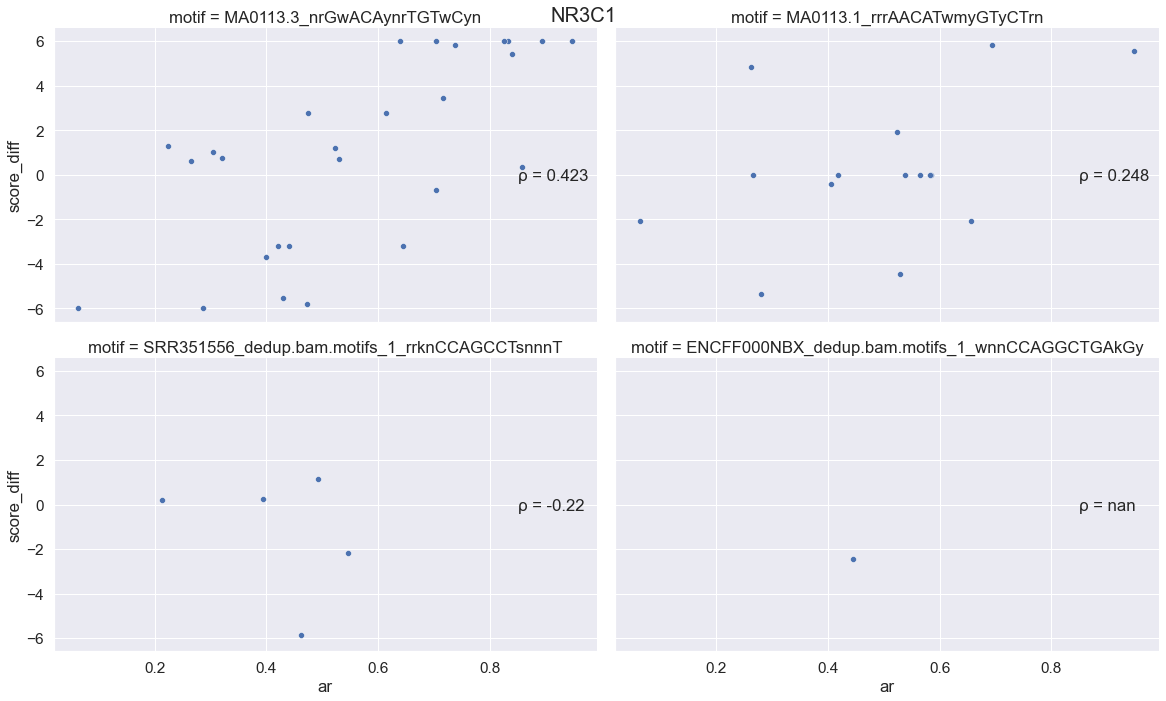

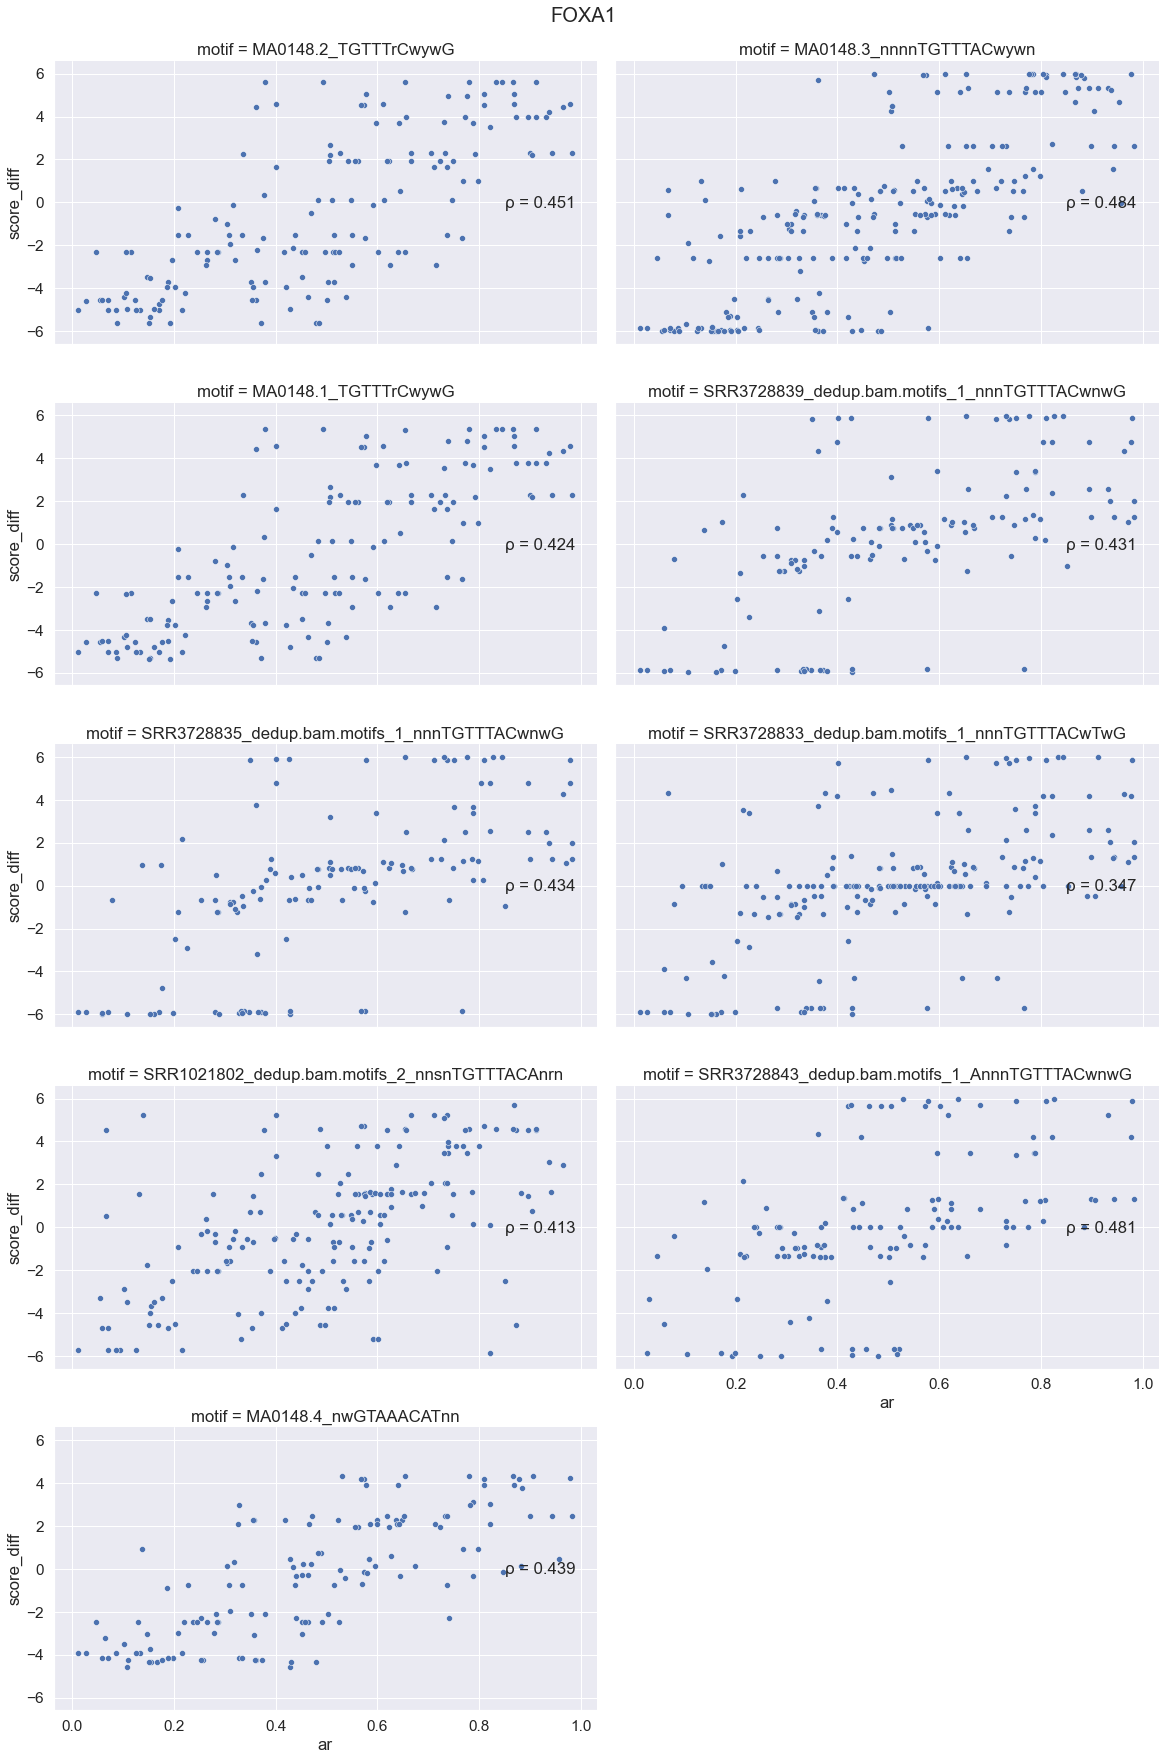

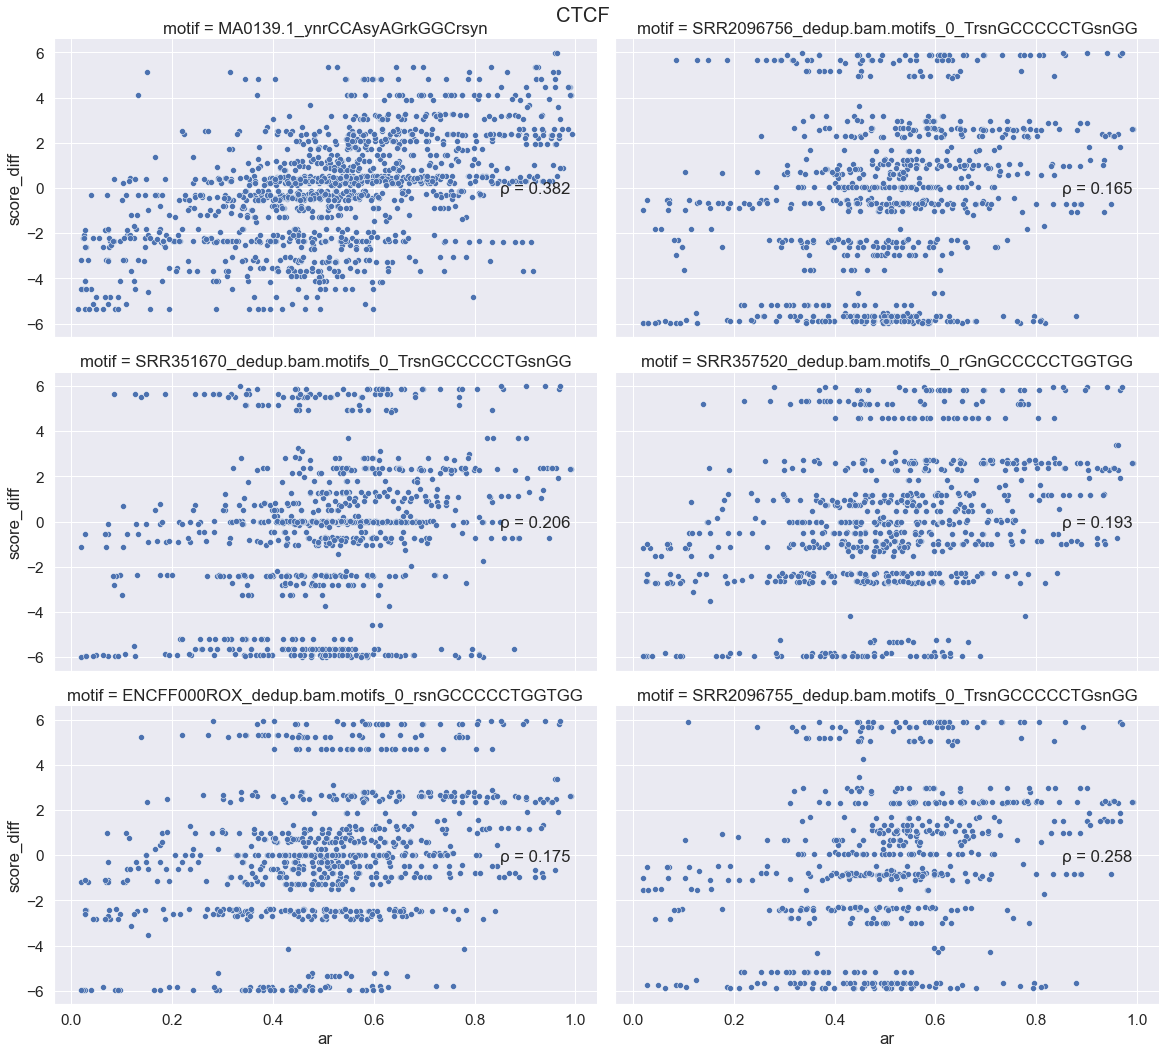

In [174]:
with sns.plotting_context("notebook", font_scale=1.4, rc={"figure.dpi":500, 'savefig.dpi':300}):
    for factor, score_set in scores.items():
        plot_data = score_set[round(score_set.score_diff, 6) != 0.]
        col_order = plot_data.motif.unique()
        g = sns.FacetGrid(plot_data, col="motif", height=5, aspect=1.65, col_wrap=2, col_order=col_order)
        g.map(sns.scatterplot, "ar", "score_diff")

        for ax, motif in zip(g.axes.flat, col_order):
            corr = round(correlations[factor][motif], 3)
            ax.text(0.85,-0.25,f"ρ = {corr}")

        g.fig.subplots_adjust(top=0.95)
        g.fig.suptitle(factor)
        plt.show()

In [159]:
snp_counts = []
for factor, score_set in scores.items():
    id_counts = pd.DataFrame(score_set.pivot(columns=("motif"), values=("id")).apply(lambda series: len(series.dropna().unique()), axis=0), columns=["counts"]).sort_values(by="counts", ascending=False).reset_index()
    id_counts["fraction_of_snps"] = id_counts["counts"]/rsid_counts[factor]
    id_counts["tf"] = factor
    snp_counts.append(id_counts)

snp_counts = pd.concat(snp_counts)
snp_counts.head()

,motif,counts,fraction_of_snps,tf
0,SRR7755832_dedup.bam.motifs_1_TAnnGCCCCCTGsTGG,114,0.029059,ESR1
1,MA0112.2_nnnnmAGGTCACCCTGACCy,113,0.028804,ESR1
2,SRR7755784_dedup.bam.motifs_0_TrnnGCCCCCTGsTGG,111,0.028295,ESR1
3,SRR7755811_dedup.bam.motifs_1_TrnnGCCmCCTGsTGG,108,0.027530,ESR1
4,MA0112.1_CCAGGTCACCrTGrCCym,106,0.027020,ESR1


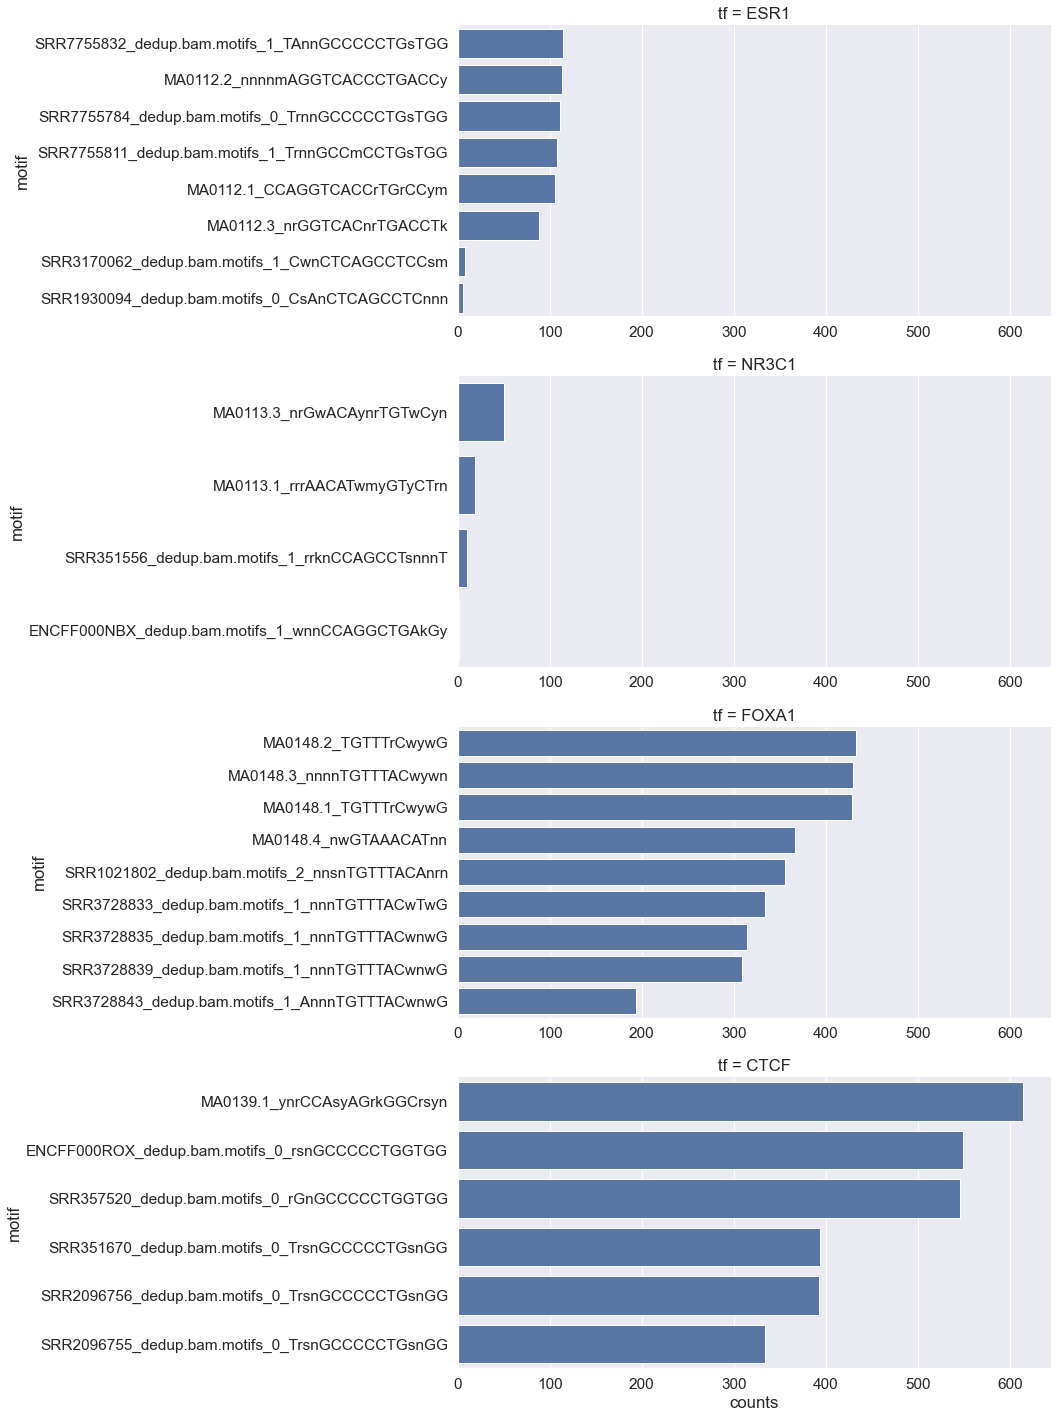

In [167]:
with sns.plotting_context("notebook", font_scale=1.4, rc={"figure.dpi":500, 'savefig.dpi':300}):    
    g = sns.FacetGrid(snp_counts, sharex=True, sharey=False, row="tf", height=5, aspect=3)
    g.map(sns.barplot, "counts", "motif")


    for axis in g.axes.flat:
        axis.tick_params(labelbottom=True)

    plt.tight_layout()

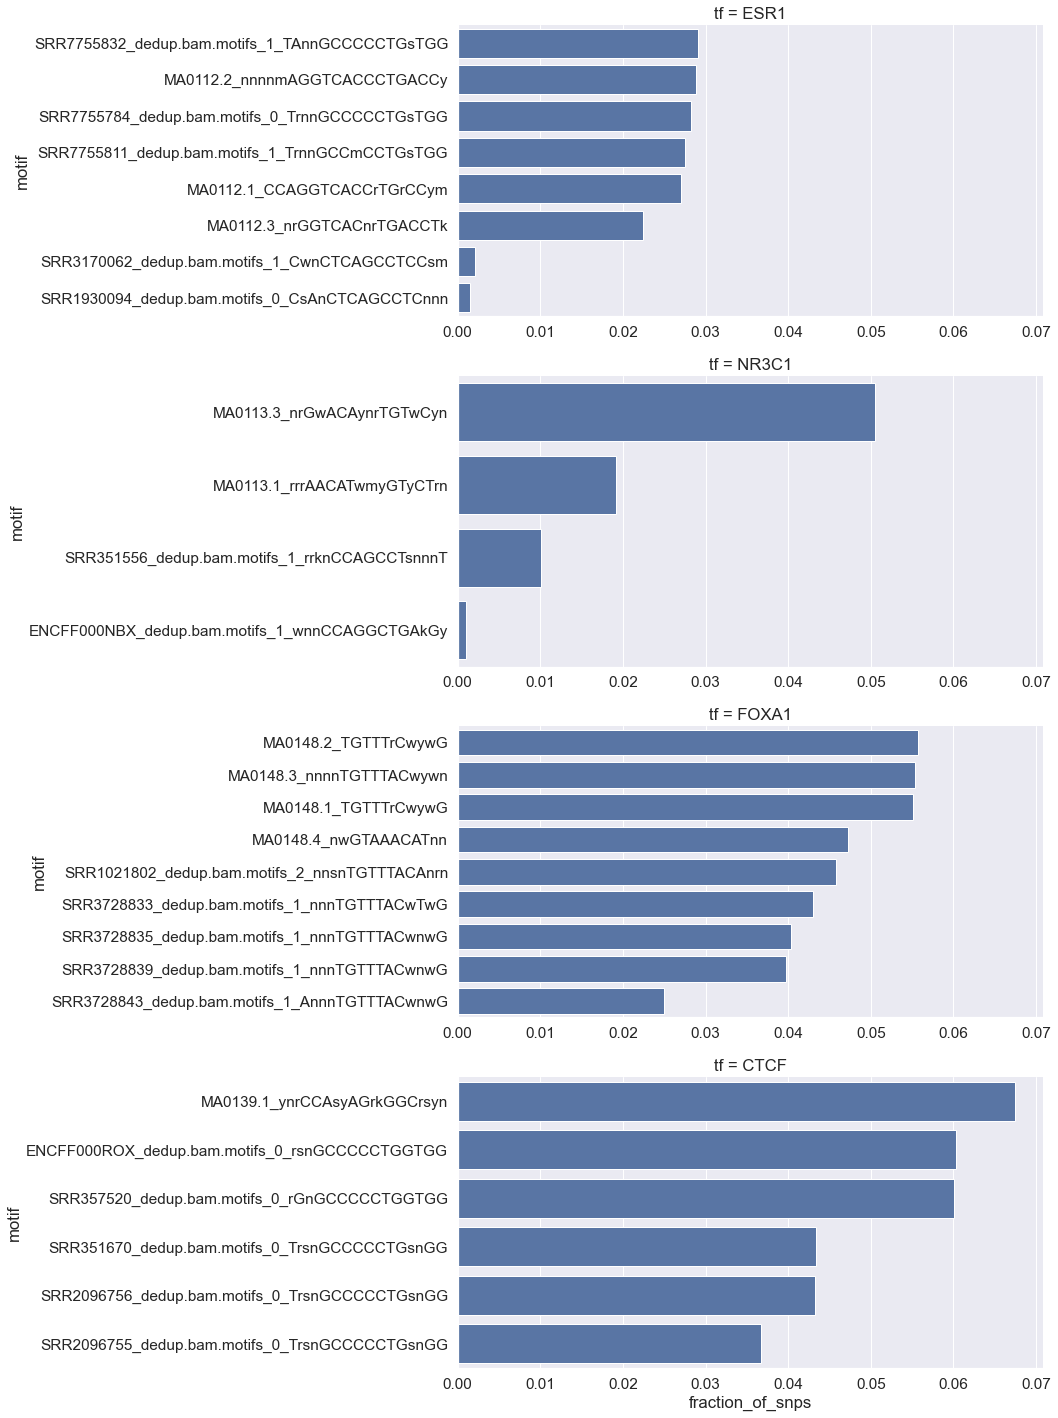

In [166]:
with sns.plotting_context("notebook", font_scale=1.4, rc={"figure.dpi":500, 'savefig.dpi':300}):    
    g = sns.FacetGrid(snp_counts, sharex=True, sharey=False, row="tf", height=5, aspect=3)
    g.map(sns.barplot, "fraction_of_snps", "motif")

    for axis in g.axes.flat:
        axis.tick_params(labelbottom=True)

    plt.tight_layout()